In [1]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi

from library.fvm.solver import Solver, Settings
from library.fvm.ode import RK1
import library.fvm.reconstruction as recon
import library.fvm.timestepping as timestepping
import library.fvm.flux as flux
import library.fvm.nonconservative_flux as nc_flux
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.basisfunctions import Basisfunction, Legendre_shifted
from library.model.models.basismatrices import Basismatrices

from library.model.model import *
import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.misc.io as io
from library.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper


import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.mesh.mesh import convert_mesh_to_jax
import argparse

No module named 'precice'


In [2]:


bcs = BC.BoundaryConditions(
    [
        BC.Wall(physical_tag="top"),
        BC.Wall(physical_tag="bottom"),
        BC.Wall(physical_tag="left"),
        BC.Wall(physical_tag="right"),
    ]
)

def custom_ic(x):
    Q = np.zeros(3, dtype=float)
    Q[0] = np.where(x[0] < 5., 0.005, 0.001)
    return Q

ic = IC.UserFunction(custom_ic)

model = ShallowWater2d(
    aux_fields=['dudx', 'dvdy'],
    parameters={'g': 9.81},
    boundary_conditions=bcs,
    initial_conditions=ic,
    settings={},
)

main_dir = os.getenv("SMS")
mesh = petscMesh.Mesh.from_gmsh(
    os.path.join(main_dir, "meshes/channel_quad_2d/mesh.msh")
)

class SWESolver(Solver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):
        dudx = compute_derivatives(Q[1]/Q[0], mesh, derivatives_multi_index=[[0, 0]])[:,0]
        dvdy = compute_derivatives(Q[2]/Q[0], mesh, derivatives_multi_index=[[0, 1]])[:,0]
        Qaux = Qaux.at[0].set(dudx)
        Qaux = Qaux.at[1].set(dvdy)
        return Qaux
    
settings = Settings(
    name="ShallowWater",
    compute_dt=timestepping.adaptive(CFL=0.45),
    time_end=6.0,
    output_snapshots=100,
    output_dir=f"outputs/shallow_water",
)

# mesh = convert_mesh_to_jax(mesh)
solver = SWESolver()
Qnew, Qaux = solver.jax_fvm_unsteady_semidiscrete(mesh, model, settings)

io.generate_vtk(os.path.join(settings.output_dir, f"{settings.name}.h5"))
# postprocessing.vtk_interpolate_3d(model, settings.output_dir,  os.path.join(settings.output_dir, f"{settings.name}.h5"), scale_h=100.)


iteration: 1.0, time: 0.05079640961073845, dt: 0.05079640961073845, time_stamp: 0.06060606060606061
iteration: 2.0, time: 0.0991940721178376, dt: 0.048397662507099155, time_stamp: 0.06060606060606061
iteration: 3.0, time: 0.14579477311657862, dt: 0.04660070099874103, time_stamp: 0.12121212121212122
iteration: 4.0, time: 0.19028957823327006, dt: 0.04449480511669144, time_stamp: 0.18181818181818182
iteration: 5.0, time: 0.2332828465618951, dt: 0.04299326832862505, time_stamp: 0.24242424242424243
iteration: 6.0, time: 0.2754901588138795, dt: 0.04220731225198443, time_stamp: 0.24242424242424243
iteration: 7.0, time: 0.31724625068937873, dt: 0.041756091875499245, time_stamp: 0.30303030303030304
iteration: 8.0, time: 0.35872497540905524, dt: 0.04147872471967653, time_stamp: 0.36363636363636365
iteration: 9.0, time: 0.40002148683976124, dt: 0.04129651143070602, time_stamp: 0.36363636363636365
iteration: 10.0, time: 0.4411897701802836, dt: 0.04116828334052236, time_stamp: 0.42424242424242425


{'length': 10.0, 'width': None, 'dx': 0.2, 'dy': None, 'ncellx': 50.0, 'ncelly': None}


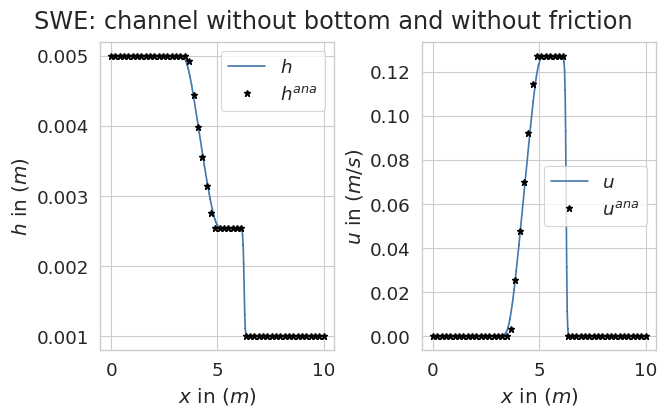

In [3]:
fig = plots_paper.plot_swe(os.path.join(settings.output_dir, settings.name + ".h5"))